# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Auteurs : Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>


<img src='./Figures/logo_p.jpg' width=200>


## 1. Ecoulement de couette plan.

### 1.1 Etude analytique 

$\textbf{Schéma du problème étudié :}$

<img src='./Figures/couette.PNG' width=500>

$\textbf{Hypothèses :}$
 - (H1) La paroi supérieure est mobile, la paroi inférieure est immobile.
 - (H2) L'écoulement est incompressible.
 - (H3) L'écoulement est permanent.
 - (H4) Le gradient de pression est nul selon x. Autrement dit, la paroi supérieure est le seul moteur de l'écoulement 

 
On cherche $\underline u$ de la forme $\underline u(x,y)= u(x,y)\underline{e_x}$.

$\textbf{Conditions aux limites :}$  
  - en $y=+\frac{e}{2}, \underline{u}= U\underline{e_x}$  d'après (H1)
  - en $y=-\frac{e}{2}, \underline{u}= 0$                d'après (H1)
  
$\textbf{Résolution : }$
D'après (H2) on montre que $\underline u= u(y)\underline{e_x}$ 

On résout l'équation de Navier-Stockes pour l'écoulement considéré :

$\begin{array}{rcl}
\rho(\frac{\partial \underline{u}}{\partial t}+ \underline{u}\cdot\underline{\underline{grad}}(\underline{u}))&=&-\underline{grad}(p)+\rho \underline{g} + \mu \underline{\Delta} \underline{u} \\
0&=&-\underline{grad}(p)+\rho \underline{g} + \mu \underline{\Delta} \underline{u} \ \  \textrm{d'après (H2) et (H3)}
\end{array}$


On projette cette équation sur les axes $x$ et $y$ :
$ \left\{
    \begin{array}{ll}
        \mu\frac{\partial^2 u}{\partial x^2} = \frac{\partial p}{\partial x} = 0 \ \ \textrm{d'après (H4)}\\
        -\rho g = \frac{\partial p}{\partial y}\\
    \end{array}
\right.
$

Ainsi on montre que le profil de vitesse est linéaire selon $y$ :
$\begin{equation}
        u(y)= U(\frac{y}{e}+\frac{1}{2})
    \end{equation}$
    
Par ailleurs, le profil de pression est aussi linéaire selon $y$ :
$\begin{equation}
        p(y)= p_0 - \rho g y
    \end{equation}$


### 1.2 Etude numérique 

#### Import des fichiers et des modules utiles pour programmer un code SPH.

In [22]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *
import numba 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Définition des grandeurs du problèmes et du fluide

In [2]:
#COUETTE PARAMETERS
e = 0.5 #Half width (m)
U = 1 # Upper bound velocity (m/s)
#FLUID PARAMETERS
Re = 1 # Reynolds number
rhoF = 1000
mu = rhoF*U*e/Re #Dynamic Vicosity (Pa.s)
grav = np.array([0.0,0.0])  #Gravity (m.s-2)
#grav= np.array([0.0,-9.81])
c0 = 10*U  #(m/s)
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF

#### Définition des propriétés des particules

In [13]:
#PARTICLE & SPACES PARAMETERS : 
N = 4   
M = 8          
dr = 2*e/(M*N) #Particle radius
h = smthfc*dr  
m=dr*dr*rhoF
lspace = 2*h
#COMPUTATION DOMAIN : 
xOrigin = 0
yOrigin = -e-nBound*dr
xSize = 10*lspace
ySize = 2*e+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize

#### Création du domaine de calcul

Pour notre projet nous avons crée un nouveau type de particules dont le FLAG est MOBILEBOUND. Celles-ci permettent de modéliser le mouvement d'une paroi mobile dont on impose le mouvement. 

Ce nouveau type de particule est défini dans [src/sphvar.py](src/sphvar.py)

Les murs seront composés d'une couche de *nBound =4* particules *fictives*. Ce nombre est suffisant pour éviter la pénétration du mur.

In [14]:
#INIT PART:
part = init_particles()
part = addBox(part,[0,-e,xSize,2*e],FLUID,dr,rhoF)                  #Fluid domain
part = addBox(part,[0,-e-nBound*dr,xSize,nBound*dr],BOUND,dr,rhoF)  #Bound domain
part = addBox(part,[0,e,xSize,nBound*dr],MOBILEBOUND,dr,rhoF)       #Moving bound domain
#PERIODICITY VECTOR
vecPer = np.array([xSize,0])
posSpace,neibSpace,partSpace,listNeibSpace = init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr,vecPer)
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)

#### Affichage du domaine 

<IPython.core.display.Javascript object>


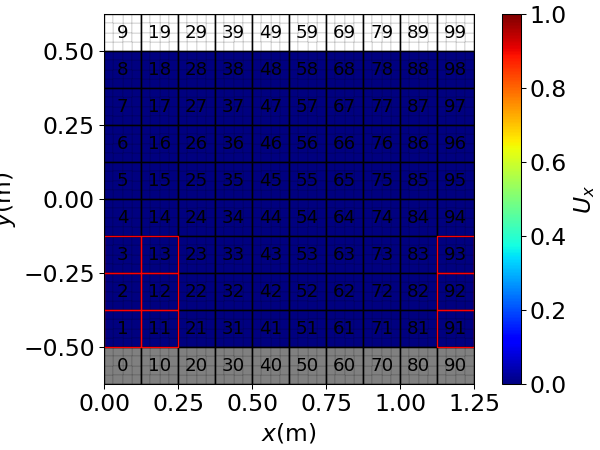

In [16]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

#### Affichage des espaces

In [17]:
plotSpaces(posSpace,'k',lspace,1)
neibSpace[2][neibSpace[2]>-1]
spacesOutline(posSpace[neibSpace[2][neibSpace[2]>-1]],'r',lspace,1)

#### Initialisation de la vitesse de la paroi supérieure

In [18]:
part[:,VEL] = initMobileBoundVelocity((part[:,INFO]==MOBILEBOUND), part[:,VEL], U)

#### Interpolation de la vitesse et de la masse volumique au bord 

In [19]:
part[:,RHO],part[:,VEL] =interpolateBoundaryPeriodicX((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,aW,h,m,B,rhoF,gamma,grav,vecPer[0],shepardMin)

#### Gestion des enregistrements

In [20]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Couette_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

#### Gestion du pas de temps et des fréquences de sorties des figures

In [21]:
# Here we specify the output frequencies
dt_figure = 0.025*e**2*rhoF/mu
t_print = 0
t_end = 3
# Time management
t=0
it=0
im_count=0

#### Programmation de la solution analytique

In [11]:
#Analytical solution for the velocity with renormalization 
ytab = np.linspace(-1,1,100)
Utab = (U/2)*(ytab/(2*e) + 1)

### 1.3 Simulation SPH

<IPython.core.display.Javascript object>


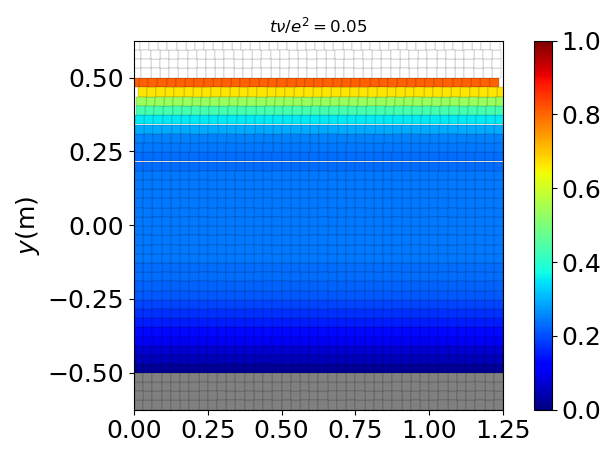

<IPython.core.display.Javascript object>


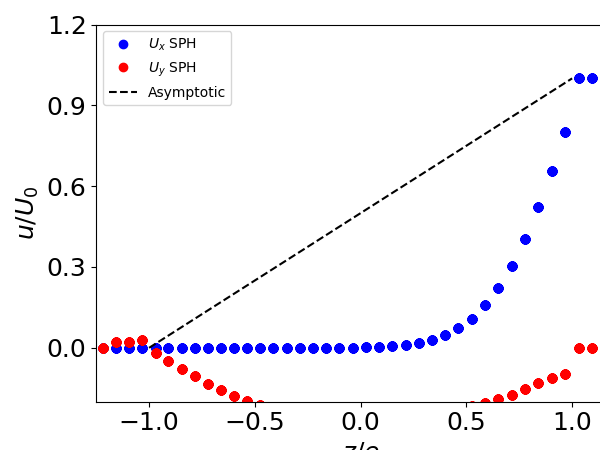

KeyboardInterrupt: 

In [12]:
%matplotlib notebook
while t<t_end:
    #STEP1 : CFL Computation 
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation of the density and the velocy near bounds
    part[:,RHO],part[:,VEL] =interpolateBoundaryPeriodicX((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,vecPer[0],shepardMin)
    #STEP3 : Interpolation of the density and the velocy near mobile bounds
    part[:,RHO], part[:, VEL] = interpolateMobileBoundaryPeriodicX((part[:,INFO]==MOBILEBOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     np.array([U, 0.0]),\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,vecPer[0],shepardMin)
    
    #STEP4 : Computation of density and forces
    part[:,FORCES],part[:,DRHODT] = computeForcesMorrisPeriodicX((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu,vecPer[0])
    #STEP5 : Time integration for fluid particle
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStepPeriodicX((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt,vecPer[0])
    #STEP6 : Time integration for mobile bound particle 
    part[:,POS], part[:,RHO] = integrationStepPeriodicX_Moving_Bound((part[:,INFO]==MOBILEBOUND),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt,vecPer[0])
    
    #STEP7 : correct particle density if too low
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    
    #STEP8 : Neighbours update 
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t\nu/e^2 = %2.2f$'%(t*mu/rhoF/e**2))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$u/U_0$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        
        #FIGURE DISPLAY
        fig2 = plt.figure(2)
        plt.clf()
        plt.plot(part[:,POS[1]]/e,part[:,VEL[0]]/U,'bo',label=r'$U_x$ SPH')
        plt.plot(part[:,POS[1]]/e,part[:,VEL[1]]/U,'ro',label=r'$U_y$ SPH')
        plt.plot(ytab,Utab,'--k',label=r'Asymptotic')
        #uan = analyticalCouetteFlow(ytab,U,e,timetab*rhoF/mu*e**2/tau)
        #plt.plot(ytab,uan,'--r',label='Analytical')
        plt.xlabel('$z/e$',fontsize=18)
        plt.ylabel('$u/U_0$',fontsize=18)
        plt.xlim(-1-nBound*dr/e,1+nBound*dr/e)
        plt.ylim(-0.2,1.2) 
        plt.legend(loc='upper left')
        plt.tight_layout()
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        plt.tight_layout()
        plt.show(block=False)
        plt.draw()
        figname = os.path.join(figures_directory,r'UV_%06d.png'%im_count)
        fig2.savefig(figname,bbox_inches='tight')
        fig2.canvas.draw()
        plt.pause(0.01)
        im_count = im_count+1
        t_print +=dt_figure
        

### 1.4 Analyse des résultats